In [1]:
%matplotlib ipympl

import sympy as sp
import matplotlib.tri as tri
import numpy as np
from IPython.display import Math, display

def output(dictionary, n, lhs, s='K'):
    for i in range(1,n+1):
        i1_string = rf'{s}={i}:\qquad '
        i2_string = rf'{lhs}={sp.latex(dictionary[i])}'.replace(s,str(i))
        display(Math(i1_string+i2_string))

def output_sp(element, lhs):
    display(Math(rf'{lhs}={sp.latex(element)}'))

xi1, xi2, B, H, x1, x2 = sp.symbols('xi_1 xi_2 B H x_1 x_2')

# **Aufgabe 12** Poisson-Gleichung, Teil 2: Finite Elemente Modellierung
Hier können die Anzahl der Elemente in $x_1$- und $x_2$-Richtung, sowie die Abmessungen $B$ und $H$ als auch der (konstante) Funktionswert $u_0(\mathbf{x})$ am Dirichlet-Rand $\partial\hat{\Omega}_D$ verändert werden.

In [2]:
n_elem_x = 2              # Anzahl der Elemente in x_1-Richtung
n_elem_y = 2              # Anzahl der Elemente in x_2-Richtung
B_value = 3               # Abmessung B
H_value = 2               # Abmessung H
u0_value = 0              # Konstanter Funktionswert am Dirichlet-Rand

f_symb = x1**2+x2**2      # Quellfunktion f(x1, x2)
g_symb = x2               # Funktion am Neumann-Rand g(x2)

Ergänzend seien hier nocheinmal das Definitionsgebiet $\hat{\Omega}$ mit Dirichlet- und Neumann-Rand $\partial\hat{\Omega}_D$ bzw. $\partial\hat{\Omega}_N$ und die Nummerierung der Elemente $K$ und der globalen Freiheitsgrade $I$ dargestellt. Ebenfalls

<img src="pics/domain.png" width=500>

In [3]:
only_dirichlet = False
supress_output = True

order = 'bilinear' # Ordnung der Elemente
dim = 2 # Dimension
n_elem = int(n_elem_x*n_elem_y) # Anazhl der Elemente
n_dof = int((n_elem_x+1)*(n_elem_y+1)) # Anzahl der globalen Freiheitsgrade
n_dof_loc = 4 if order == 'bilinear' else None # Anzahl der Elementfreiheitsgrade

# Symbolische Variablen der globalen Freiheitsgrade
u_hat_symb = sp.symbols([rf'\hat{{u}}_{i}' for i in range(1,n_dof+1)])
u_hat_symb = sp.Matrix(u_hat_symb)

# Symbolische Variablen der globalen Ansatzfunktionen
u_I_symb = sp.symbols([rf'u^{{{i}}}(\mathbf{{x}})' for i in range(1,n_dof+1)])
u_I_symb = sp.Matrix(u_I_symb)

# Symbolische Variablen der lokalen Freiheitsgrade
NK_symb = sp.symbols([rf'N^{{{K}\,{d}}}(\mathbf{{x}})' for K in range(1,n_elem+1) for d in range(1,n_dof_loc+1)])
NK_symb = sp.Matrix(NK_symb)

## Diskretes Rechengebiet (Mesh)

Als erstes werden hier alle nötigen Informationen über das diskrete Rechengebiet (Mesh), welche für die anschließende Berechnung der Elementsteifigkeitsmatrizen, der Elementkraftvektoren, etc. benötigt werden, ermittelt.

Wichtig sind hierbei die Knotenpunktkoordinaten $\mathbf{x}^{K,d}$ der $K$ Elemente.

### Knotenpunktkoordinaten

In [4]:
# Koordinaten der Knotenpunkte
x = sp.Matrix([[i*B_value/n_elem_x, j*H_value/n_elem_y] for j in range(n_elem_y+1) for i in range(n_elem_x+1)])

# Elemente mit Freiheitsgrade
K_dof = {}

# Elemente mit Knotenpunkten
xK = {}
for j in range(n_elem_y):
    for i in range(n_elem_x):
        
        K = j*n_elem_x+i+1

        # Fuege globale Freiheitsgrade zu den Elementen hinzu
        d1 = j*(n_elem_x+1)+i+1      # links unten
        d2 = d1 + 1                  # rechts unten
        d3 = d1 + (n_elem_x+1) + 1   # rechts oben
        d4 = d1 + (n_elem_x+1)       # links oben

        K_dof[K] = [d1, d2, d3, d4]
        
        # Ermittle Knotenpunktkoordinaten der Elemente
        xK[K] = sp.zeros(n_dof_loc, dim)
        
        xK[K][0,0] = i*sp.Rational(B_value,n_elem_x)
        xK[K][1,0] = (i+1)*sp.Rational(B_value,n_elem_x)
        xK[K][2,0] = (i+1)*sp.Rational(B_value,n_elem_x)
        xK[K][3,0] = i*sp.Rational(B_value,n_elem_x)

        xK[K][0,1] = j*sp.Rational(H_value,n_elem_y)
        xK[K][1,1] = j*sp.Rational(H_value,n_elem_y)
        xK[K][2,1] = (j+1)*sp.Rational(H_value,n_elem_y)
        xK[K][3,1] = (j+1)*sp.Rational(H_value,n_elem_y)
    
if not supress_output: output(xK, n_elem, r'\mathbf{x}^{K,d}')

## Neumann Rand

Am Neumann-Rand "wirkt" die Funktion $\overline{g}(\mathbf{x}),\mathbf{x}\in\partial\hat{\Omega}_N$. Diese Funktion muss anschließend bei der Berechnung der Elementkraftvektoren an jenen Elementen $K$ welche diesen Rand beinhalten berücksichtigt werden. Da die Integration sämtlicher Integrale am Einheitselement durchgeführt werden, müssen auch die Rand(linien)elemente ensprechend transformiert werden.

### Inverse Transformation
An dieser Stelle werden die inversen Transformationen $(T^F_\Gamma)^{-1}(\xi_2):\Gamma\rightarrow\Gamma^F$ der Rand(linien)elemente $F$ entlang des Neumann-Randes ermittelt. Diese lassen sich einfach durch die eindimensionale affine Transformation
$$
    (T^F_\Gamma)^{-1}(\xi_2)=x_2=x_{2,0}+(x_{2,1}-x_{2,0})\xi_2
$$
ermitteln.

In [5]:
neu_right_T = np.arange((n_elem_x+1),(n_elem_x+1)*(n_elem_y+1)+1,n_elem_x+1)
F_dof = {}

TFm1_Gamma = {}
TF_Gamma = {}
for F in range(1, n_elem_y+1):
    
    dof0 = neu_right_T[F-1]
    dof1 = neu_right_T[F-1]+n_elem_y

    if F == 1:
        F_dof[F] = [dof1]
    elif F == n_elem_y:
        F_dof[F] = [dof0]
    else:
        F_dof[F] = [dof0, dof1]
    
    x20 = x[dof0-1,1]
    x21 = x[dof1-1,1]
    
    TFm1_Gamma[F] = x20+(x21-x20)*xi2
    TF_Gamma[F] = (x2-x20)/(x21-x20)

neu_right = neu_right_T[1:-1]

if not supress_output: output(TFm1_Gamma, n_elem_y, r'(T^{F}_\Gamma)^{-1}(\xi_2)', s='F')

### Transformation
Aus der obigen inversen Transformation $(T^F_\Gamma)^{-1}(\xi_2):\Gamma\rightarrow\Gamma^F$ lässt sich leicht die Transformation $T^F_\Gamma(x_2):\Gamma^F\rightarrow\Gamma$ für das jeweilige Randelement $F$ durch Umformung ermitteln. Dabei ergibt sich
$$
    T^F_\Gamma(x_2) = \xi_2=\frac{x_2-x_{2,0}}{x_{2,1}-x_{2,0}}
$$

In [6]:
if not supress_output: output(TF_Gamma, n_elem_y, r'T^{F}_\Gamma(\xi_2)', s='F')

### Inverse Jacobimatrix
Die inverse Jacobimatrix $(J^F_\Gamma)^{-1}$, welche in diesem eindimensionalen Fall gleich der Determinante $\det (J^F_\Gamma)^{-1}$ ist, berechnet sich aus der inversen Transformation $(T^F_\Gamma)^{-1}(\xi_2)$ als
$$
    (J^F_\Gamma)^{-1}=\frac{\mathrm{d}\xi_2}{\mathrm{d} x_2}=\det (J^F_\Gamma)^{-1}
$$

In [7]:
JFm1_Gamma = {}

for F in range(1, n_elem_y+1):
    JFm1_Gamma[F] = sp.diff(TFm1_Gamma[F],xi2)

if not supress_output: output(JFm1_Gamma, n_elem_y, r'(J^{F}_\Gamma)^{-1}(\xi_2)=\det (J^{F}_\Gamma)^{-1}', s='F')

### Jacobimatrix

Die Jacobimatrix $J^F_\Gamma$, welche in diesem eindimensionalen Fall gleich der Determinante $\det J^F_\Gamma$ ist, berechnet sich aus der Transformation $T^F_\Gamma(x_2)$ als
$$
    J^F_\Gamma=\frac{\mathrm{d}x_2}{\mathrm{d} \xi_2}=\det J^F_\Gamma
$$

In [8]:
JF_Gamma = {}

for F in range(1, n_elem_y+1):
    JF_Gamma[F] = sp.diff(TF_Gamma[F],x2)

if not supress_output: output(JF_Gamma, n_elem_y, r'J^{F}(\xi_2)', s='F')

## Finite Elemente

### Ansatzfunktionen

Im weiteren Verlauf werden sämtliche Berechnungen wie etwa jene der Transformationsabbildungen, der Elementsteifigkeitsmatrizen, der Elementkraftvektoren, etc. am Einheitselement durchgeführt, d.h. die Ansatzfunktionen $N^d(\mathbf{\xi})$ sind der Ausgangspunkt aller im Folgenden durchgeführten Berechnungen.

Für ein bilineares Element ergeben sich die Ansatzfunktionen zu 

In [9]:
N = sp.Matrix([(1-xi1)*(1-xi2),
               xi1*(1-xi2),
               xi1*xi2,
               xi2*(1-xi1)])
if not supress_output: output_sp(N, r'N^d(\mathbf{\xi})')

### Inverse Transformation

Die inversen Transformationen $(T^K)^{-1}(\mathbf{\xi}):\Omega\rightarrow\Omega^K$ werden mit der isoparametrischen Transformation
$$
    (T^K)^{-1}(\mathbf{\xi})=\sum\limits_{d=1}^{4}N^{d}(\mathbf{\xi})\,\mathbf{x}^{K,d}
$$
durchgeführt, wobei $\mathbf{x}^{K,d}$ die Knotenpunktkoordinaten des Elements $K$ sind, welche ganz oben bereits ermittelt wurden.

In [10]:
TKm1 = {}

for K in range(1,n_elem+1):
    TKm1[K] = sp.zeros(dim,1)
    for d in range(n_dof_loc):
        TKm1[K] += N[d]*xK[K][d,:].T
    TKm1[K].simplify()

if not supress_output: output(TKm1, n_elem, r'(T^{K})^{-1}(\mathbf{\xi})')

### Transformation

Die Transformation $T^K(\mathbf{x}):\Omega^4\rightarrow\Omega$ lässt sich einfach für jedes Element durch elementare Umformungen aus obiger inverser Transformation ermitteln.

In [11]:
TK = {}

for K in range(1,n_elem+1):
    TKsol = sp.solve([TKm1[K][0]-x1,TKm1[K][1]-x2],(xi1, xi2))
    TK[K] = sp.Matrix([TKsol[xi1],TKsol[xi2]])

if not supress_output: output(TK, n_elem, r'T^{K}(\mathbf{x})')

### Inverse Jacobimatrix

Die Inverse Jacobimatrix $(\mathbf{J}^K)^{-1}$ berechnet sich gemäß Definition mit
$$
    (\mathbf{J}^K)^{-1}=\left[\frac{\partial (T^K)^{-1}(\mathbf{\xi})}{\partial\xi_j}\right]=\left[\frac{\partial x_i}{\partial\xi_j}\right]
$$

In [12]:
JKm1 = {}

for K in range(1,n_elem+1):
    JKm1[K] = TKm1[K].jacobian([xi1, xi2])

if not supress_output: output(JKm1, n_elem, r'(J^{K})^{-1}')

Aus den inversen Jacobimatrizen der jeweiligen Elemente können schließlich auch deren Determinanten bestimmt werden, welche für die Transformation der Integrale zur Berechnung der Elementsteifigkeitsmatrizen und -kraftvektoren benötigt werden.

In [13]:
detJKm1 = {}

for K in range(1,n_elem+1):
    detJKm1[K] = JKm1[K].det()

if not supress_output: output(detJKm1, n_elem, r'\det (J^{K})^{-1}')

### Jacobimatrix

Die Jacobimatrix $\mathbf{J}^K$ berechnet sich gemäß Definition mit
$$
    \mathbf{J}^K=\left[\frac{\partial T^K(\mathbf{x})}{\partial x_j}\right]=\left[\frac{\partial\xi_i}{\partial x_j}\right]
$$

In [14]:
JK = {}

for K in range(1,n_elem+1):
    JK[K] = TK[K].jacobian([x1, x2])

if not supress_output: output(JK, n_elem, r'J^{K}')

### Ableitungen der Elementansatzfunktionen nach den globalen Koordinaten

Zur Berechnung der Elementsteifigkeitsmatrizen werden die Ableitungen der Ansatzfunktionen $\frac{\partial N^{K,d}(\mathbf{x})}{\partial x_i}$ am allgemeinen Element nach den globalen Koordinaten $\mathbf{x}$ benötigt.

Wie in der Übung gezeigt, ergeben sich diese nach Anwendung der Kettenregel gemäß
$$
    \frac{\partial N^{K,d}(\mathbf{x})}{\partial x_i} = \frac{\partial N^d(\mathbf{\xi})}{\partial \xi_j}\frac{\partial \xi_j}{\partial x_i}
$$

In [15]:
dNddxij = N.jacobian([xi1, xi2])

dNKddxi = {}

for K in range(1,n_elem+1):
    dNKddxi[K] = dNddxij*JK[K]

if not supress_output: output(dNKddxi, n_elem, r'\frac{\partial N^{K,d}}{\partial x_i}')

### Elementsteifigkeitsmatrix

Mit den oben ermittelten Ableitungen der Ansatzfunktionen und der Determinante der inversen Jacobimatrix des jeweiligen Elements kann nun das Integral zur Berechnung der Einträge der Elementsteifigkeitsmatrix am Einheitselement mit Definitionsgebiet $\Omega$ mit
$$
    A^{K,d;K,e} = \int\limits_\Omega N^{K,d}_{,i}(\mathbf{x})N^{K,e}_{,i}(\mathbf{x})\det(\mathbf{J}^K)^{-1}\,\mathrm{d}\Omega
$$
angegeben werden.

In [16]:
AKdKe = {}

for K in range(1,n_elem+1):

    AKdKe[K] = sp.zeros(n_dof_loc,n_dof_loc)
    for d in range(n_dof_loc):
        for e in range(n_dof_loc):
            scalar_prod = 0
            for i in range(dim):
                scalar_prod += dNKddxi[K][d,i]*dNKddxi[K][e,i]
            AKdKe[K][d,e] = sp.integrate(scalar_prod,(xi1,0,1),(xi2,0,1))*detJKm1[K]
            
if not supress_output: output(AKdKe, n_elem, r'A^{K,d;K,e}')

### Elementkraftvektor

Analog lässt sich mit der Quellfunktion $f(\mathbf{x})$, den Ansatzfunktionen und der Determinante der inversen Jacobimatrix des jeweiligen Elements das Integral zur Berechnung der Einträge des Elementkraftvektors mit
$$
    F^{K,d} = \int\limits_\Omega f((T^K)^{-1}(\mathbf{\xi})) N^{d}(\mathbf{\xi})\det(\mathbf{J}^K)^{-1}\,\mathrm{d}\Omega+\int\limits_\Gamma\overline{g}((T^F_\Gamma)^{-1}(\mathbf{\xi}))N^{K,d}(\mathbf{\xi})\,\mathrm{d}\Gamma
$$
angegeben werden.

Zuvor werden die in der Angabe angegebenen skalaren Funktionen, die Quellfunktion $f(\mathbf{x})$ und die Funktion $\overline{g}(\mathbf{x})$ entlang des Neumann-Randes, auf das Einheitselement transformiert, d.h. $f((T^K)^{-1}(\mathbf{\xi}))$ und $\overline{g}((T^K)^{-1}(\mathbf{\xi}))$.

In [17]:
f = {}

for K in range(1,n_elem+1):
    if isinstance(f_symb, int) or isinstance(f_symb, float):
        f[K] = f_symb
    else:
        f[K] = f_symb.subs({x1:TKm1[K][0],x2:TKm1[K][1]}).expand()

if not supress_output: output(f, n_elem, r'f((T^{K})^{-1}(\mathbf{x}))')

In [18]:
g = {}

if only_dirichlet:
    for F in range(1,n_elem_y+1):
        g[F] = 0
elif not only_dirichlet:
    for F in range(1,n_elem_y+1):
        if isinstance(g_symb, int) or isinstance(g_symb, float):
            g[F] = g_symb
        else:
            g[F] = g_symb.subs(x2,TFm1_Gamma[F]).expand()

if not supress_output: output(g, n_elem_y, r'g((T^{F}_\Gamma)^{-1}(x_2))', s='F')

Mit den transformierten Funktionen $f((T^K)^{-1}(\mathbf{\xi}))$ und $\overline{g}((T^K)^{-1}(\mathbf{\xi}))$ lassen sich somit die Elementkraftvektoreinträge berechnen.

In [19]:
FKd = {}

for K in range(1,n_elem+1):
    FKd[K] = sp.zeros(n_dof_loc,1)

    if K % n_elem_x == 0:
        
        F = int(K/n_elem_x)
        neu_dof = F_dof[F]
   
        for d in range(n_dof_loc):
            
            FKd[K][d] = sp.integrate(f[K]*N[d],(xi1,0,1),(xi2,0,1))*detJKm1[K] + \
                        sp.integrate(g[F]*N[d],(xi2,0,1))*JFm1_Gamma[F]
            FKd[K][d] = FKd[K][d].subs(xi1,B_value)
            
    else:
    
        for d in range(n_dof_loc):
       
            FKd[K][d] = sp.integrate(f[K]*N[d],(xi1,0,1),(xi2,0,1))*detJKm1[K]

if not supress_output: output(FKd, n_elem, r'F^{K,d}')

## Assemblierung

Nachdem oben nun alle elementbezogenen Größen ermittelt wurden müssen diese zum Erhalt einer **global stetigen Lösung** assembliert werden. Der erste Schritt besteht darin, die Stetigkeitsmatrix zu ermitteln.

### Stetigkeitsmatrix

Mit der Stetigkeitsmatrix $C^{IK,d}$ lassen sich die Elementansatzfunktionen $N^{K,d}(\mathbf{x})$, welche nur am Element $K$ selbst definiert sind, zu den global stetigen Ansatzfunktionen $u^{I}(\mathbf{x})$ zusammensetzen. Diesen Vorgang nennt man **Assemblierung**.

Die Steteigkeitsmatrix $C^{IK,d}$ ergibt sich dabei wie in der Übung besprochen zu

In [20]:
# Konstruktion der Stetigkeitsmatrix
dof_elems = {}

for dof in range(n_dof):

    x_dof = x[dof,0]
    y_dof = x[dof,1]
    dof_elems[dof+1] = []

    for K, coords in xK.items():

        for d in range(coords.rows):
            
            xd = coords.row(d)[0]
            yd = coords.row(d)[1]

            if xd.equals(x_dof) and yd.equals(y_dof):
                dof_elems[dof+1].append((K,d+1))

CIKd = sp.zeros(n_dof, n_elem*n_dof_loc)

for I in dof_elems:
    for Kd in dof_elems[I]:
        i = I-1
        j = n_dof_loc*(Kd[0]-1)+Kd[1]-1

        CIKd[i,j] = 1

if not supress_output: output_sp(CIKd, r'[C^{IK,d}]')

### Globale Ansatzfunktionen

Mit der Stetigkeitsmatrix erhätl man schließlich die global stetigen Ansatzfunktionen gemäß
$$
    u^I(\mathbf{x}) = C^{IK,d}\,N^{K,d}(\mathbf{x})
$$

In [21]:
if not supress_output: display(Math(rf'{sp.latex(u_I_symb)}={sp.latex(CIKd)}\cdot {sp.latex(NK_symb)}'))

### Globale Steifigkeitsmatrix

Die globale Steifigkeitsmatrix $[A^{IJ}]$ lässt sich gemäß
$$
    A^{IJ}=C^{IK,d}A^{K,d;K,e}_{\mathrm{tot}}C^{JL,e}\quad\Leftrightarrow\quad\mathbf{A}=\mathbf{C}\cdot\mathbf{A}_{\mathrm{tot}}\cdot\mathbf{C}^\top
$$
berechnen, wobei sich die nicht-assemblierte Steifigkeitsmatrix $[A^{K,d;K,e}_{\mathrm{tot}}]$ durch die Elementsteifigkeitsmatrizen $[A^{K,d;K,e}]$ entlang der Diagonalen ergibt, d.h.

In [22]:
null = sp.zeros(n_dof_loc, n_dof_loc)
A_tot = [[None for _ in range(n_elem)] for _ in range(n_elem)]

for i in range(n_elem):
    for j in range(n_elem):
        if i == j:
            A_tot[i][j] = AKdKe[i+1]
        else:
            A_tot[i][j] = null

A_tot = sp.Matrix(A_tot)

if not supress_output: output_sp(A_tot, r'[A^{K,d;K,e}_{\mathrm{tot}}]')

Somit erhält man für die globale Steifigkeitsmatrix $[A^{IJ}]$

In [23]:
A = CIKd*A_tot*CIKd.T

if not supress_output: output_sp(A, r'[A^{IJ}]')

### Globaler Kraftvektor

Der globale Kraftvektor $[F^{I}]$ lässt sich gemäß
$$
    F^{I}=C^{IK,d}F^{K,d}\quad\Leftrightarrow\quad\mathbf{F}=\mathbf{C}\cdot\mathbf{F}_{\mathrm{tot}}
$$
berechnen, wobei sich der nicht-assemblierte Kraftvektor $[F^{K,d}_{\mathrm{tot}}]$ durch vertikale Stapelung der Elementkraftvektoren $[F^{K,d}]$ ergibt, d.h.

In [24]:
F_tot = []

for i in range(n_elem):
    F_tot.append(FKd[i+1].T)
F_tot = sp.Matrix(sp.BlockMatrix(F_tot)).T

if not supress_output: output_sp(F_tot, r'[F^{K,d}_{\mathrm{tot}}]')

Somit erhält man für den globalen Kraftvektor $[F^{I}]$

In [25]:
F = CIKd*F_tot

if not supress_output: output_sp(F, r'[F^I]')

### Lineares Gleichungssystem ohne Berücksichtigung der Dirichlet-Randbedingungen

Das nach der Assemblierung entstehende lineare Gleichungssystem **ohne** Berücksichtigung der Dirichlet-Randbedingungen
$$
    A^{IJ}\hat{u}^I=F^{I}\quad\Leftrightarrow\quad\mathbf{A}\cdot\hat{\mathbf{u}}=\mathbf{F}
$$
zur Ermittlung der gesuchten Freiheitsgrade and den Knotenpunkten $\hat{u}^I$ schreibt sich als

In [26]:
if not supress_output: display(Math(rf'{sp.latex(A)}\cdot{sp.latex(u_hat_symb)}={sp.latex(F)}'))

### Lineares Gleichungssystem mit Berücksichtigung der Dirichlet-Randbedingungen

Nun müssen noch die Dirichlet-Randbedingungen in das obige Gleichungssystem eingearbeitet werden. Gemäß der Angabe gilt dort $u(\mathbf{x})=0,\mathbf{x}\in\partial\hat{\Omega}_D$. Berücksichtigt man dies, ergibt sich das folgende zu lösende Gleichungssystem

In [27]:
A_dir = []
F_dir = []

# Bestimme Freiheitsgrade welche zum Dirichlet-Rand gehören
dir_bottom = np.arange(1, (n_elem_x+1)+1, 1)
dir_left = np.arange((n_elem_x+1)+1,(n_elem_x+1)*n_elem_y+2, (n_elem_x+1))
dir_top = np.arange((n_elem_x+1)*n_elem_y+2, (n_elem_x+1)*(n_elem_y+1)+1)

if only_dirichlet:
    dir_right = np.arange((n_elem_x+1),(n_elem_x+1)*(n_elem_y+1)+1,n_elem_x+1)[1:-1]
    dir_dofs = np.concatenate((dir_bottom, dir_left, dir_top, dir_right), axis=0)

elif not only_dirichlet:
    dir_dofs = np.concatenate((dir_bottom, dir_left, dir_top), axis=0)

# Ersetze alle Zeilen mit Verträglichkeit durch die Dirichlet Randbedingungen
for i in range(n_dof):
    if i+1 in dir_dofs:
        row = [0 for _ in range(n_dof)]
        row[i] = 1
        A_dir.append(row)
        F_dir.append(u0_value)
    else:
        A_dir.append(A[i,:])
        F_dir.append(F[i,0])

A_dir = sp.Matrix(A_dir)
F_dir = sp.Matrix(F_dir)

In [28]:
if not supress_output: display(Math(rf'{sp.latex(A_dir)}\cdot{sp.latex(u_hat_symb)}={sp.latex(F_dir)}'))

## Lösung

Löst man nun das obige Gleichungssystem mit Berücksichtigung der Dirichlet-Randbedingungen, so erhält man die gesuchten Knotenpunktwerte $\hat{u}_I$. Die approximierte Lösungsfunktion ergibt sich damit schließlich mit den insgesamt $N$ Freiheitsgraden als Linearkombination der ermittelten Knotenpunktwerte $\hat{u}_I$ mit den zugehörigen globalen, stetigen Ansatzfunktionen $u^I(\mathbf{x})$ als
$$
    u(\mathbf{x})\approx u^h(\mathbf{x})=\sum_{I=1}^{N}\hat{u}_I\,u^I(\mathbf{x})
$$
Diese approximierte Lösungsfunktion $u^h(\mathbf{x})$ sein nun unten dargestellt.

In [29]:
eq = A_dir*u_hat_symb - F_dir

u_hat = sp.solve(eq)
u_hat_sorted = dict(sorted(u_hat.items(), key=lambda item: int(item[0].name.split('_')[1])))

u_hat_num = np.array([v for v in u_hat_sorted.values()]).astype(np.float64)

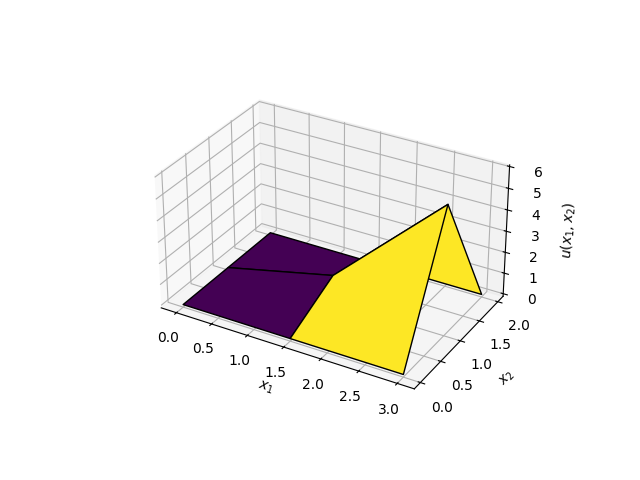

In [30]:
xx = np.linspace(0,B_value,n_elem_x+1)
yy = np.linspace(0,H_value,n_elem_y+1)
zz = u_hat_num

X, Y = np.meshgrid(xx,yy)
Z = zz.reshape(n_elem_y+1, n_elem_x+1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$u(x_1, x_2)$')
#ax.set_zticks([])
world_limits = ax.get_w_lims()
H = 0.6*np.max([B_value, H_value])
ax.set_box_aspect((world_limits[1]-world_limits[0],world_limits[3]-world_limits[2],H))
plt.show()